# **1. Importing Data and Libraries**

In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!/bin/bash
!kaggle datasets download ruvelpereira/mit-plagairism-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/ruvelpereira/mit-plagairism-detection-dataset
License(s): unknown
  0% 0.00/7.57M [00:00<?, ?B/s]
100% 7.57M/7.57M [00:00<00:00, 672MB/s]


In [4]:
from zipfile import ZipFile

dataset = '/content/mit-plagairism-detection-dataset.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('Dataset is extracted')

Dataset is extracted


In [5]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Subtract
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

import re
import nltk
import spacy
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

Converting Text file to CSV

In [6]:
with open('/content/train_snli.txt') as file:
  data = file.readlines()

#prepare csv file
with open('data.csv','w', newline='') as csvfile:
  filenames = ['source_txt', 'plagiarism_txt', 'label']
  writer = csv.DictWriter(csvfile, fieldnames=filenames)

  writer.writeheader()
  for line in tqdm(data):
    parts = line.strip().split('\t')
    source_txt = parts[0]
    plagiarism_txt = parts[1]
    label = int(parts[2])

    writer.writerow({
        'source_txt': source_txt,
        'plagiarism_txt': plagiarism_txt,
        'label': label
    })

print('CSV file created successfully...')

  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


# **2. Loading Data**

In [7]:
df = pd.read_csv('/content/data.csv')
df.head()

,source_txt,plagiarism_txt,label
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
2,Children smiling and waving at camera,There are children present,1
3,Children smiling and waving at camera,The kids are frowning,0
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0


In [8]:
df.shape

(367373, 3)

In [9]:
df.duplicated().sum()

np.int64(454)

In [10]:
df.drop_duplicates(inplace=True)

# **3. Cleaning Text**

In [11]:
import re, string


def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #Replace newlines with spaces
    text = text.translate(str.maketrans("", "", string.punctuation)) #Remove punctuation
    return text


# Apply cleaning
df["source_clean"] = df["source_txt"].astype(str).apply(clean_text)
df["plag_clean"] = df["plagiarism_txt"].astype(str).apply(clean_text)

# **4. Tokenization**

In [12]:
source = df['source_clean'].tolist()
plag = df['plag_clean'].tolist()
labels = df['label'].values


tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(source + plag)


source_seq = tokenizer.texts_to_sequences(source)
plag_seq = tokenizer.texts_to_sequences(plag)


max_len = 50
source_pad = pad_sequences(source_seq, maxlen=max_len)
plag_pad = pad_sequences(plag_seq, maxlen=max_len)

# **5. Split Data**

In [13]:
X_train_src, X_test_src, X_train_plag, X_test_plag, y_train, y_test = train_test_split(
source_pad, plag_pad, labels, test_size=0.2, random_state=42)

# **6. Build LSTM Model**

In [14]:
#Siamese LSTM network

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_dim = 64

input_a = Input(shape=(max_len,))
input_b = Input(shape=(max_len,))

embedding = Embedding(vocab_size , embedding_dim , input_length = max_len)
lstm = LSTM(lstm_dim)

encoded_a = lstm(embedding(input_a))
encoded_b = lstm(embedding(input_b))

merged = Subtract()([encoded_a , encoded_b])
merged = Dense(64 , activation = "relu")(merged)
merged = Dropout(0.5)(merged)
out = Dense(1,activation="sigmoid")(merged)

model = Model(inputs=[input_a , input_b], outputs=out)
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  3,874,432 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 64)        │          0 │ lstm[0][0],       │
│                     │                   │            │ lstm[1][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,928,065 (14.98 MB)

 Trainable params: 3,928,065 (14.98 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# **7. Train Model**

In [16]:
history = model.fit(
    [X_train_src, X_train_plag],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 89s 11ms/step - accuracy: 0.7461 - loss: 0.4966 - val_accuracy: 0.8392 - val_loss: 0.3709
Epoch 2/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - accuracy: 0.8545 - loss: 0.3379 - val_accuracy: 0.8568 - val_loss: 0.3414
Epoch 3/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.8839 - loss: 0.2828 - val_accuracy: 0.8639 - val_loss: 0.3309
Epoch 4/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9022 - loss: 0.2430 - val_accuracy: 0.8667 - val_loss: 0.3328
Epoch 5/10
7339/7339 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.9200 - loss: 0.2090 - val_accuracy: 0.8676 - val_loss: 0.3418


# **8. Evaluation**

In [17]:
pred = model.predict([X_test_src, X_test_plag])
pred_label = (pred > 0.5).astype(int)


print("Accuracy:", accuracy_score(y_test, pred_label))
print(classification_report(y_test, pred_label))

2294/2294 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Accuracy: 0.8620543987790255
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     36778
           1       0.84      0.90      0.87     36606

    accuracy                           0.86     73384
   macro avg       0.86      0.86      0.86     73384
weighted avg       0.86      0.86      0.86     73384



# **9. Plot Training Curves**

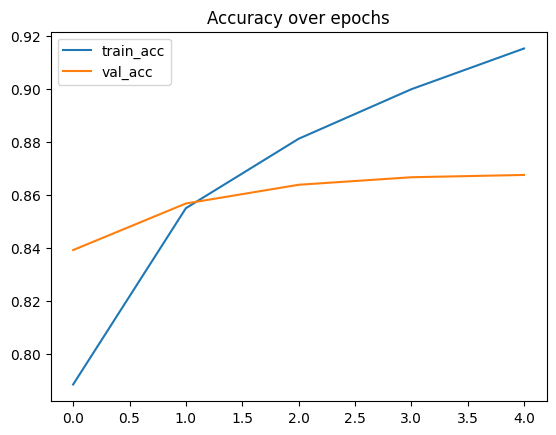

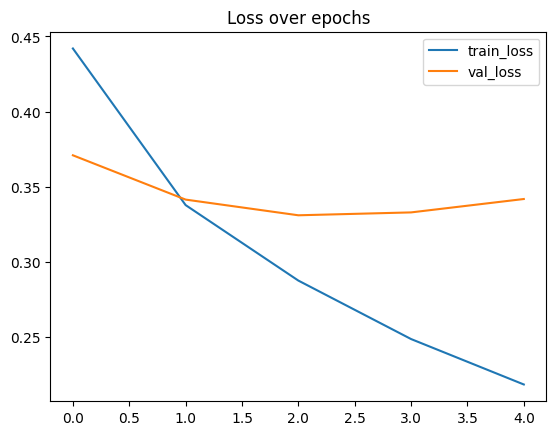

In [18]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# **10. Saving Model**

In [19]:
import pickle

# Save fitted Tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the trained model
with open('Siamese_LSTM_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# **11. Sample Prediction**

In [20]:
idx = 0
src = X_test_src[idx:idx+1]
plg = X_test_plag[idx:idx+1]
print("Pred:", model.predict([src, plg])[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Pred: 0.8060622


Testing Model on User Inputs

In [21]:
def predict_pair(source_text, plag_text, tokenizer, max_len):
    # Convert to sequences
    src_seq = tokenizer.texts_to_sequences([source_text])
    plg_seq = tokenizer.texts_to_sequences([plag_text])

    # Pad
    src_pad = pad_sequences(src_seq, maxlen=max_len)
    plg_pad = pad_sequences(plg_seq, maxlen=max_len)

    # Predict
    pred = model.predict([src_pad, plg_pad])[0][0]

    # Show result
    print("Prediction score:", pred)
    if pred > 0.5:
        print("✅ Likely PLAGIARIZED")
    else:
        print("❌ Likely NOT PLAGIARIZED")

    return pred

In [22]:
src = "A woman is standing outside wearing glasses."
plg = "A woman wearing glasses is outdoors."

predict_pair(src, plg, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction score: 0.9733201
✅ Likely PLAGIARIZED


np.float32(0.9733201)

In [23]:
src = "Two kids are sleeping on a bench."
plg = "A car is driving on the road."

predict_pair(src, plg, tokenizer, max_len)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction score: 0.034570765
❌ Likely NOT PLAGIARIZED


np.float32(0.034570765)